Pytorch中的优化算法比较
===
Pytorch中有如下的优化器：
- SGD
- Momentum
- Adagrad
- RMSprop
- Adadelta
- Adam

常用的就是SGD,Momentum,RMSprop,Adam这四个
![images](Images/03/00/05_08_001.jpeg)

# 1.终极目标

## 1.1.训练目标分析
假设全部训练样本的集合为$S$，损失度量为$L(x;\theta)$，其中$x$代表单个样本，而$\theta$则是优化参数，那么我们可以构建损失函数：
$$L(\theta)=\frac{1}{\left| S \right|}\sum_{x \in S}L(x;\theta) \tag{1}$$
而训练的终极目标，则是找到$L(\theta)$的一个全局最优点-这里的最优是最小的意思

## 1.2.梯度下降
为了完成这个目标，我们可以使用梯度下降法
$$\theta_{n+1}=\theta_n-\epsilon \nabla_{\theta}L(\theta_n) \tag{2}$$
其中$\epsilon > 0$称为学习率，这里刚好也是迭代的步长（后面我们会看到步长不一定等于学习率）。梯度下降有多种理解方式，由于一般都有$\epsilon \ll 1$，所以这里我们将它改变为
$$\frac{\theta_{n+1}-\theta_n}{\epsilon}=-\nabla_{\theta}L(\theta_n)=0 \tag{3}$$
那么左边就近似于$\theta$的导数（假设它是时间$t$的函数），于是我们可以得到$ODE$动力系统：
$$\dot{\theta}=-\nabla_{\theta}L(\theta) \tag{4}$$
而(2)则是(4)的一个欧拉解法。这样一来，梯度下降实际上就是用欧拉解法去求解动力系统(4)，由于(4)是一个保守动力系统，因此它最终可以收敛到一个不动点（让$\dot{\theta}=0$），并且可以证明稳定的不动点是一个极小值点（但未必是全局最小的）

# 2.随机梯度下降(SGD-Stochastic Gradient Descent)

## 2.1.从梯度下降到随机梯度下降
(2)我们一般称为“全量梯度下降”，因为它需要所有样本来计算梯度，这是梯度下降的一个显著缺点：当样本成千上万时，每迭代一次需要的成本太大，甚至可能达到难以进行。于是我们想随机从$S$中随机抽取一个子集$R \subseteq S$，然后只用$R$去计算梯度并完成单次迭代。我们记
$$L_R(\theta)=\frac{1}{\left|R\right|}\sum_{x \in R}L(x;\theta)$$
然后公式(2)就变为了
$$\theta_{n+1}=\theta_n-\epsilon\nabla_{\theta}L_R(\theta_n)$$

最原始的随机梯度下降算法主要依据当前梯度$\frac{\partial{L}}{\partial{w}}$乘上一个系数学习率$\alpha$来更新模型权重$w$的
$$\omega_{t+1}=\omega_t-\alpha\frac{\partial{L}}{\partial{\omega_t}}$$

条件允许情况下，在使用$SGD$时，开始使用小$batch size$和大学习率，然后让$batch size$慢慢增加，学习率慢慢减小。

# 2.Momentum优化器
SGD方法的一个缺点是其更新方向完全依赖于当前batch计算出的梯度，因而十分不稳定。Momentum算法借用了物理中的动量概念，它模拟的是物体运动时的惯性，即更新的时候在一定程度上保留之前更新的方向，同时利用当前batch的梯度微调最终的更新方向。这样一来，可以在一定程度上增加稳定性，从而学习地更快，并且还有一定摆脱局部最优的能力：
$$
\begin{eqnarray}
\nu_t&=&\gamma \times \nu_{t-1} + \alpha \times \nabla_{\Theta}J(\Theta) \\
\Theta&=&\Theta-\nu_t
\end{eqnarray}
$$
Momentum算法会观察历史梯度$\nu_{t-1}$，若当前梯度的方向与历史梯度一致（表明当前样本不太可能为异常点），则会增强这个方向的梯度，若当前梯度与历史梯方向不一致，则梯度会衰减。一种形象的解释是：我们把一个球推下山，球在下坡时积聚动量，在途中变得越来越快，$\gamma$可视为空气阻力，若球的方向发生变化，则动量会衰减。特点：
- 下降初期时，使用上一次参数更新，下降方向一致，乘上较大的$\gamma$能够进行很好的加速
- 下降中后期时，在局部最小值来回震荡的时候，$gradient\to 0$，$\gamma$使得更新幅度增大，跳出陷阱
- 在梯度改变方向的时候，$\gamma$能够减少更新 总而言之，momentum项能够在相关方向加速SGD，抑制振荡，从而加快收敛

# 3.Adagrad(自适应学习算法)
通过将学习率除以S的平方根来研究学习率分量，其中S为当前和过去平方梯度的累积和（即直到时间t）。请注意，和SGD算法相同，自适应学习率算法中的梯度分量也保持不变
$$\omega_{t+1}=\omega_t-\frac{\alpha}{\sqrt{S_t+\epsilon}} \times \frac{\partial{L}}{\partial{\omega_t}}$$
其中
$$S_t=S_{t-1}+[\frac{\partial{L}}{\partial{\omega_t}}]^2$$
并将S的初始值置0.请注意，这里在分母中添加了$\epsilon$。Keras称之为模糊因子，它是一个小的浮点值，以确保我们永远不会遇到除零的情况。

# 4.RMSprop-Root Mean Square Prop(均方根传递算法)
Momentum优化算法中，初步解决了优化中摆动幅度大的问题。所谓的摆动幅度就是在优化中经过更新之后参数的变化范围，如下图所示，蓝色的为Momentum优化算法
![images](Images/03/00/05_08_002.png)
为了进一步优化损失函数在更新中存在摆动幅度过大的问题，并且进一步加快函数的收敛速度，RMSProp算法对权重$W$和偏置$b$的梯度使用了微分平方加权平均数。 

RMSprop是在AdaGrad算法上进行改进的另一种自适应学习率算法。其中，假设在第$t$轮迭代过程中，各个公式如下所示：
$$\omega_{t+1}=\omega_t-\frac{\alpha}{\sqrt{S_t+\epsilon}} \times \frac{\partial{L}}{\partial{\omega_t}}$$
其中
$$S_t=\beta S_{t-1}+(1-\beta)[\frac{\partial{L}}{\partial{\omega_t}}]^2$$
并将S的初始值置0.

# 5.Adadelta(自适应增量算法)
与RMSprop算法类似，Adadelta是在AdaGrad算法的基础上针对学习率进行改进的一种自适应算法。Adadelta应该是是“自适应增量”的缩写，其中，delta表示当前权重与新更新权重之间的差值。

Adadelta算法和RMSprop算法的区别，在于Adadelta算法中用delta的指数加权平均值D来替代原来在Adadelta算法中的学习率参数
$$\omega_{t+1}=\omega_t-\frac{\sqrt{D_{t-1}+\epsilon}}{\sqrt{S_t+\epsilon}} \times \frac{\partial{L}}{\partial{\omega_t}}$$
其中
$$
\begin{split}
D_t&=\beta D_{t-1}+(1-\beta)[\delta{\omega_t}]^2 \\
S_t&=\beta S_{t-1}+(1-\beta)[\frac{\partial{L}}{\partial{\omega_t}}]^2
\end{split}
$$
并把D和S的初始值置0. 

# 6.Adam-Adaptive Moment Estimation-适应矩估计算法
Momentum可以使用类似于物理中的动量来累积梯度,RMSprop可以使得收敛速度更快同时使得波动的幅度更小；将两者结合起来就形成了Adam优化器。
$$
\begin{split}
\hat{V}_t&=\frac{V_t}{1-\beta_1^t} \\
\hat{S}_t&=\frac{S_t}{1-\beta_2^t}
\end{split}
$$
其中
$$
\begin{split}
V_t&=\beta_1V_{t-1}+(1-\beta_1)\frac{\partial{L}}{\partial{\omega_t}} \\
S_t&=\beta_2S_{t-1}+(1-\beta_2)[\frac{\partial{L}}{\partial{\omega_t}}]^2
\end{split}
$$
V和S的初始值置0.

Epoch: 1 Training...
Epoch: 2 Training...
Epoch: 3 Training...
Epoch: 4 Training...
Epoch: 5 Training...
Epoch: 6 Training...
Epoch: 7 Training...
Epoch: 8 Training...
Epoch: 9 Training...
Epoch: 10 Training...
Epoch: 11 Training...
Epoch: 12 Training...
Epoch: 13 Training...
Epoch: 14 Training...
Epoch: 15 Training...
Epoch: 16 Training...
Epoch: 17 Training...
Epoch: 18 Training...
Epoch: 19 Training...
Epoch: 20 Training...


(0, 0.5)

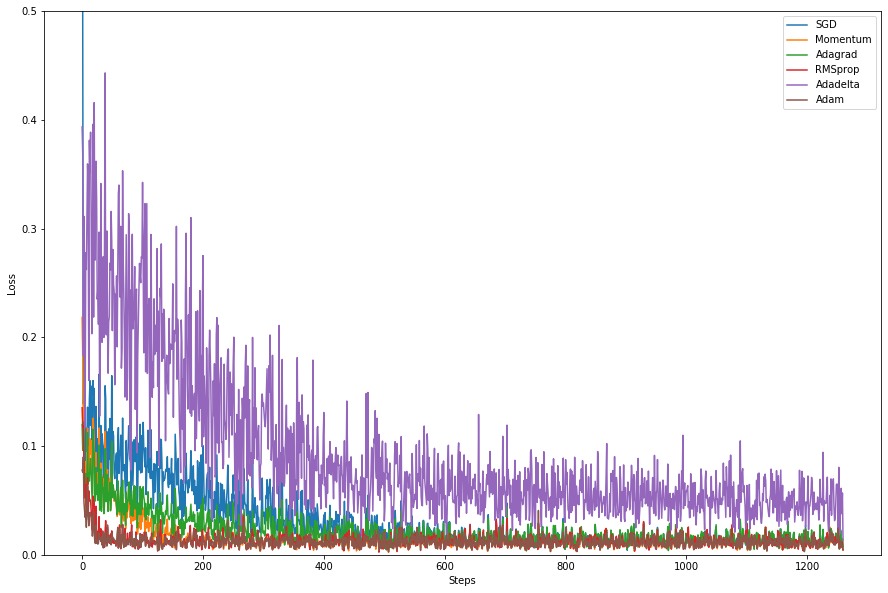

In [1]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
torch.manual_seed(1) # 设定随机数种子
# 定义超参数
BATCH_SIZE = 16 # 批大小
EPOCH = 20 # 迭代次数

x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
y = x.pow(2) + 0.1*torch.normal(torch.zeros(*x.size()))

# 将数据转换为torch的dataset格式
torch_dataset = Data.TensorDataset(x, y)
# 将torch_dataset置入Dataloader中
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=2)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)
        self.predict = torch.nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

# 为每个优化器创建一个Net
net_SGD = Net()
net_Momentum = Net()
net_Adagrad = Net()
net_RMSprop = Net()
net_Adadelta = Net()
net_Adam = Net()
nets = [net_SGD, net_Momentum, net_Adagrad, net_RMSprop, net_Adadelta, net_Adam]

# 初始化优化器
opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=0.03)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=0.01, momentum=0.8)
opt_Adagrad = torch.optim.Adagrad(net_Adagrad.parameters(), lr=0.01)
opt_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr=0.01, alpha=0.9)
opt_Adadelta = torch.optim.Adadelta(net_Adadelta.parameters(), lr=0.03)
opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=0.01, betas=(0.9, 0.99))

optimizers = [opt_SGD, opt_Momentum, opt_Adagrad, opt_RMSprop, opt_Adadelta, opt_Adam]

# 定义损失函数
loss_function = torch.nn.MSELoss()
losses_history = [[], [], [], [], [], []] # 记录training时不同神经网络的loss值

for epoch in range(EPOCH):
    print('Epoch:', epoch + 1, 'Training...')
    for step, (batch_x, batch_y) in enumerate(loader):
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        for net, opt, l_his in zip(nets, optimizers, losses_history):
            output = net(b_x)
            loss = loss_function(output, b_y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            l_his.append(loss.item())

labels = ['SGD', 'Momentum', 'Adagrad', 'RMSprop', 'Adadelta', 'Adam']
plt.figure(facecolor='w', figsize=(15,10))
for i, l_his in enumerate(losses_history):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.5))

误差平面的等值线图
![images](Images/03/00/05_08_003.webp)
不同优化算法在鞍点的表现
![images](Images/03/00/05_08_004.webp)

# 7.优化算法的选择
- 目前而言，用的比较多的优化算法是SGD、动量、RMSProp、AdaDelta、Adam。
- 在稀疏数据上，一般建议使用自适应学习率算法。
- 在高度复杂的模型上，推荐使用自适应学习率算法，通常它们收敛起来比较快。
- 在其他问题中，使用自适应学习率算法通常也能取得较优的表现。同时它也额外带来了一项福利：你不用操心学习率设定问题。
- 总体而言，在自适应学习率算法中，Adam是一个比较流行的选择。
- 考虑到超参数调整的便利性，优化算法的选择还取决于你对不同算法的熟悉程度。
- Adam在不同超参数下的鲁棒性较好，不过有时你可能需要调整下$\alpha$值。